In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
#from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(8)

In [0]:
!pwd
%cd "drive/My Drive/CVProject"
!pwd

/content
/content/drive/My Drive/CVProject
/content/drive/My Drive/CVProject


In [0]:
class_names = os.listdir('UCMerced_LandUse/Train/')
target_dirs = {target: './UCMerced_LandUse/' + target for target in ['Train', 'Validation', 'Test']}

In [0]:
print(class_names)
print(target_dirs)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'storagetanks', 'runway', 'tenniscourt', 'sparseresidential']
{'Train': './UCMerced_LandUse/Train', 'Validation': './UCMerced_LandUse/Validation', 'Test': './UCMerced_LandUse/Test'}


In [0]:
def get_bottleneck_features( dataset, batch_size=64):
  print(f'Generating "{dataset}" bottleneck predictions')
  image_data_gen = ImageDataGenerator(rescale=1/255.0)
  image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                       target_size=(299, 299),
                                                        shuffle=False)
  image_count = 0
  X_batches, Y_batches = [], []
  for X, Y in image_generator:
    X_batches.append(X)
    Y_batches.append(Y)
    image_count += X.shape[0]
    # Must interrupt image_generator
    if image_count >= image_generator.n:
      break
  X = np.concatenate(X_batches)
  Y = np.concatenate(Y_batches)
  return X, Y

In [0]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in ['Train', 'Validation', 'Test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features( dataset)

Generating "Train" bottleneck predictions
Found 1785 images belonging to 21 classes.
Generating "Validation" bottleneck predictions
Found 210 images belonging to 21 classes.
Generating "Test" bottleneck predictions
Found 210 images belonging to 21 classes.


In [0]:
model = applications.InceptionResNetV2(include_top=True, weights=None, classes=num_classes)

In [0]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_813 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_813 (BatchN (None, 149, 149, 32) 96          conv2d_813[0][0]                 
__________________________________________________________________________________________________
activation_814 (Activation)     (None, 149, 149, 32) 0           batch_normalization_813[0][0]    
________________________________________________________________________________

In [0]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [0]:
X['Train'].shape[1:]

(299, 299, 3)

In [0]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
epochs = 300
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
adam = optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:

model_fit_history = model.fit(X['Train'], Y['Train'], batch_size=16, epochs=100,
                              verbose=2, validation_data=(X['Validation'], Y['Validation']))

Train on 1785 samples, validate on 210 samples
Epoch 1/100
 - 102s - loss: 0.6941 - accuracy: 0.7810 - val_loss: 15.2012 - val_accuracy: 0.1143
Epoch 2/100
 - 93s - loss: 0.6145 - accuracy: 0.8134 - val_loss: 4.7775 - val_accuracy: 0.2429
Epoch 3/100
 - 94s - loss: 0.3932 - accuracy: 0.8717 - val_loss: 3.3685 - val_accuracy: 0.4762
Epoch 4/100
 - 94s - loss: 0.2768 - accuracy: 0.9126 - val_loss: 2.1239 - val_accuracy: 0.4714
Epoch 5/100
 - 94s - loss: 0.1985 - accuracy: 0.9395 - val_loss: 2.4095 - val_accuracy: 0.5381
Epoch 6/100
 - 94s - loss: 0.1802 - accuracy: 0.9451 - val_loss: 2.8314 - val_accuracy: 0.5286
Epoch 7/100
 - 94s - loss: 0.1800 - accuracy: 0.9417 - val_loss: 2.1379 - val_accuracy: 0.5333
Epoch 8/100
 - 93s - loss: 0.1011 - accuracy: 0.9720 - val_loss: 2.5798 - val_accuracy: 0.5857
Epoch 9/100
 - 94s - loss: 0.1322 - accuracy: 0.9619 - val_loss: 3.0532 - val_accuracy: 0.5429
Epoch 10/100
 - 94s - loss: 0.1571 - accuracy: 0.9513 - val_loss: 2.4114 - val_accuracy: 0.4905


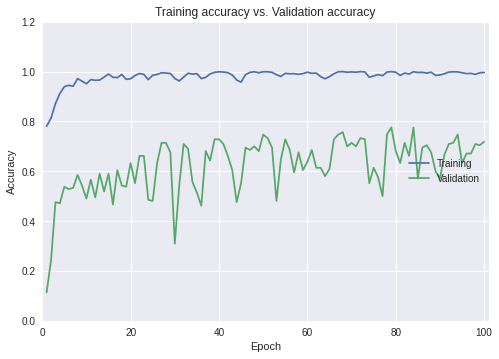

In [0]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

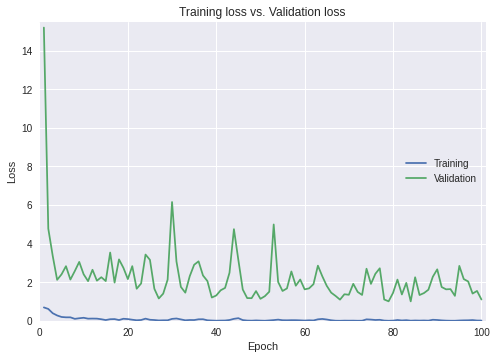

In [0]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()


In [0]:
y_pred = model.predict(np.array(X['Test']))

In [0]:
y_pred

array([[9.98973370e-01, 6.88135117e-07, 3.13691926e-05, ...,
        4.43459072e-07, 2.09720895e-07, 4.31898677e-08],
       [9.98641074e-01, 2.18256810e-06, 7.59066243e-05, ...,
        1.30562830e-06, 4.28048224e-07, 6.01287624e-08],
       [9.97900486e-01, 2.08487063e-06, 5.32184094e-05, ...,
        1.24174596e-06, 1.66680582e-06, 6.41975930e-08],
       ...,
       [4.41740511e-08, 6.28761668e-03, 2.01243500e-04, ...,
        3.35370027e-03, 3.39793926e-03, 3.19886319e-02],
       [3.53269185e-11, 1.52394659e-06, 1.00029865e-05, ...,
        9.21310573e-07, 7.45676880e-05, 9.99172449e-01],
       [2.78360268e-09, 2.04199041e-05, 1.86671004e-05, ...,
        7.75443277e-06, 5.20575995e-05, 8.00628364e-01]], dtype=float32)

In [0]:



y_pred_final = y_pred.argmax(axis = -1)

y_test = Y['Test']
ct = []
cp = []
acc = 0 
for i in range(y_test.shape[0]):
  class_true = np.where(y_test[i] == np.amax(y_test[i]))[0][0]
  ct.append(class_true)
  class_pred = y_pred_final[i]
  cp.append(class_pred)
  if class_true == class_pred:
   acc = acc + 1

accuracy = acc / y_test.shape[0]

In [0]:

print(accuracy_score(ct, cp))
print(classification_report(ct, cp))

0.7142857142857143
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.70      0.82        10
           2       0.80      0.80      0.80        10
           3       0.73      0.80      0.76        10
           4       0.86      0.60      0.71        10
           5       1.00      1.00      1.00        10
           6       1.00      0.20      0.33        10
           7       0.40      1.00      0.57        10
           8       1.00      0.60      0.75        10
           9       0.50      0.40      0.44        10
          10       0.91      1.00      0.95        10
          11       0.82      0.90      0.86        10
          12       0.35      0.70      0.47        10
          13       0.80      0.80      0.80        10
          14       0.71      1.00      0.83        10
          15       0.91      1.00      0.95        10
          16       0.50      0.10      0.17        10
        